
*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher & Ali Ahmad Khan<br>
**Date:**  21.11.2023

--- 

# Combine preprocessed datasets

This file is to construct a final counting data product that combines different counting data sources, cleanes and aggregates the data and finally adds further information from different sources. The final product can be used in the emission generator pipeline to calculate actual emissions. 

**Required steps**
- tbd


In [20]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from math import sqrt

# import custom modules
sys.path.append('../../utils')
from excel_calendar import Calendar
import data_paths

### Import and prepare datasets

In [21]:
# define file paths
mst_file_path = data_paths.MST_COUNTING_PATH + 'preprocessed_lhm_counting_data.parquet'
bast_file_path = data_paths.BAST_COUNTING_PATH + 'preprocessed_bast_counting_data.parquet'
visum_file_path = data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg'

# import and concatenate bast and mst counting data
counting_data = pd.concat([pd.read_parquet(mst_file_path), 
                           pd.read_parquet(bast_file_path)], axis = 0)

# import visum links data
visum_links = gpd.read_file(visum_file_path)

# initialize calendar object
cal_obj = Calendar()

print(f'Number of rows: {len(counting_data)}')

Number of rows: 3258862


### Prepare traffic volume dataset

In [22]:
# aggregate counts for each road_link_id and reduce to volume dataset
volume  = counting_data.groupby(['metric','road_link_id',
                                 'vehicle_class','date']).sum(numeric_only = True).loc['volume']
volume = volume.drop(['detector_id'], axis = 1)
volume = volume.reset_index()

# add road type information
road_types = visum_links.set_index('road_link_id')['road_type'].to_dict()
volume.insert(4,'road_type' , volume['road_link_id'].map(road_types))
# drop rows with road_type = none
volume = volume[volume['road_type'] != 'none']

# add day type information
dates = volume['date'].unique()
day_types = {date:cal_obj.get_day_type_combined(date) for date in dates}
volume.insert(5, 'day_type', volume['date'].map(day_types))

# drop rows with NaN values
volume = volume.dropna()

# reduce to 2019 - 2022 data
volume = volume[volume['date'].between('2019-01-01','2022-12-31')]

print(f'Number of rows: {len(volume)}\n')
print('Number of detectors on each road type:')
print(pd.Series([road_types[i] for i in volume['road_link_id'].unique()]).value_counts())

Number of rows: 634558

Number of detectors on each road type:
Local/Collector               49
Motorway-Nat                  34
TrunkRoad/Primary-City        16
TrunkRoad/Primary-National    11
Access-residential             1
Name: count, dtype: int64


### Filter for valid rows

In [23]:
# sum of all hour values of the day needs to be consistent with the sum of the day -> error_bound e=2%
e = 0.05

# Filter rows based on the condition
volume_processed = volume[
    volume.iloc[:, 6:].sum(axis=1).between(
        volume['daily_value'] * (1 - e),
        volume['daily_value'] * (1 + e)
    )
].copy()

# drop rows with daily_volume <1
volume_processed = volume_processed[volume_processed['daily_value'] > 1]

print(f'Number of rows: {len(volume_processed)}')
print(pd.Series([road_types[i] for i in volume_processed['road_link_id'].unique()]).value_counts())

Number of rows: 543286
Local/Collector               43
Motorway-Nat                  33
TrunkRoad/Primary-City        16
TrunkRoad/Primary-National    10
Access-residential             1
Name: count, dtype: int64


### Check for consistency with VISUM model

In [24]:
def iqr_mean(input, iqr_range = (5,95)):
    lower_bound = np.percentile(input, iqr_range[0])
    upper_bound = np.percentile(input, iqr_range[1])
    return np.mean(input[(input >= lower_bound) & (input <= upper_bound)])

sum_cnt_2019 = volume_processed[(volume_processed['date'].between('2019-01-01','2019-12-31')) &
                                (volume_processed['vehicle_class'] == 'SUM') &
                                (volume_processed['day_type'] == 1)]

mean_cnt_2019 = sum_cnt_2019.groupby('road_link_id')['daily_value'].apply(iqr_mean)

In [25]:
def calc_sqv(Observed, Model, f=10000): 
    return 1/(1 + sqrt(pow( Model - Observed, 2) / (f * Observed)))

visum_grp = visum_links.groupby('road_link_id')['dtv_KFZ'].sum().reset_index()
visum_grp['meanCnt'] = visum_grp['road_link_id'].map(mean_cnt_2019.to_dict())
visum_grp['sqv'] = visum_grp.apply(lambda row: calc_sqv(row['meanCnt'],
                                                        row['dtv_KFZ']), axis = 1)

visum_validation = visum_grp.dropna().copy()

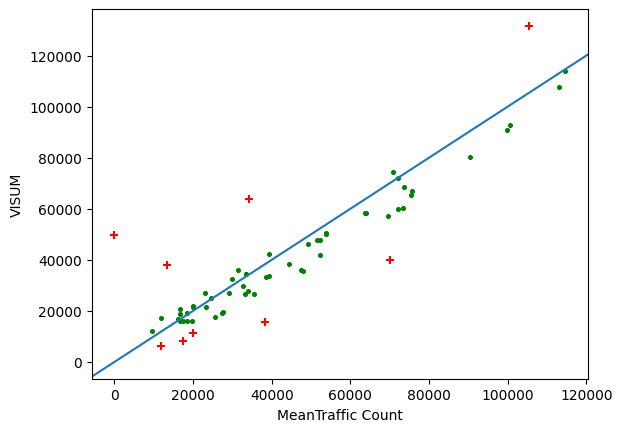

In [26]:
threshold = 0.6
visum_validation['valid'] = visum_validation['sqv']>threshold

plt.scatter(x = visum_validation[visum_validation['valid']]['dtv_KFZ'],
            y=visum_validation[visum_validation['valid']]['meanCnt'],
            marker = 'o', label = 'valid counts', color = 'green', s = 7)

plt.scatter(x = visum_validation[~visum_validation['valid']]['dtv_KFZ'],
            y=visum_validation[~visum_validation['valid']]['meanCnt'], 
            marker='+', label = 'ivalid counts', color = 'red')

plt.xlabel('MeanTraffic Count')
plt.ylabel('VISUM')

plt.axline((0,0), (1,1))

In [27]:
# delete data from ivalid road links
valid_road_links = visum_validation[visum_validation['valid']]['road_link_id']
volume_processed_valid = volume_processed[volume_processed['road_link_id'].isin(valid_road_links)]

print(f'Number of rows: {len(volume_processed_valid)}')
print(pd.Series([road_types[i] for i in volume_processed_valid['road_link_id'].unique()]).value_counts())

Number of rows: 370945
Motorway-Nat                  21
Local/Collector               19
TrunkRoad/Primary-City         8
TrunkRoad/Primary-National     6
Name: count, dtype: int64


### Flag incomplete timeseries

In [28]:
time_start = '2019-01-01'
time_end = '2022-12-31'
threshold = 0.8 #80% of days need to be included 

# find counting stations that cover
df = volume_processed_valid[(volume_processed_valid['vehicle_class'] == 'SUM') &
                (volume_processed_valid['date'].between(time_start, time_end))]

df = df.groupby('road_link_id')['daily_value'].count()
complete = df[df > threshold * df.max()]
volume_processed_valid.insert(5, 'complete', volume_processed_valid['road_link_id'].isin(complete.index))


print(f'Number of rows of complete timeseries: {len(volume_processed_valid[volume_processed_valid["complete"]])}')
print(pd.Series([road_types[i] for i in volume_processed_valid[volume_processed_valid["complete"]]["road_link_id"].unique()]).value_counts())

Number of rows of complete timeseries: 286069
Local/Collector               15
Motorway-Nat                  10
TrunkRoad/Primary-City         6
TrunkRoad/Primary-National     6
Name: count, dtype: int64


## Store as Parquet File

In [29]:
# path to mst counting data
data_path = data_paths.COUNTING_PATH

# Store the dataframe as a parquet file
volume_processed_valid.to_parquet(data_path+'counting_data_combined.parquet', index=False)